# 🚀 Fraud Detection Model Demo

This notebook demonstrates how to use your trained BERT model for fraud detection.

## 📊 Model Overview
- **Model Type**: BERT-based multiclass classifier
- **Classes**: 9 types (legitimate + 8 fraud types)
- **Input**: Text messages
- **Output**: Fraud classification with confidence scores

## 🎯 Fraud Types Detected
1. **Legitimate** - Normal, safe messages
2. **Phishing** - Attempts to steal credentials/personal info
3. **Tech Support Scam** - Fake technical support calls/messages
4. **Reward Scam** - Fake prizes/lottery winnings
5. **Job Scam** - Fraudulent employment opportunities
6. **SMS Spam** - Unwanted promotional messages
7. **Popup Scam** - Fake security alerts/warnings
8. **Refund Scam** - Fake refund/billing notifications
9. **SSN Scam** - Social Security number theft attempts

In [2]:
# Install required packages if needed (uncomment the next line if you need to install)
# !pip install torch transformers pandas numpy matplotlib seaborn

# If you get ModuleNotFoundError, restart your kernel (Kernel -> Restart) and run this cell again

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")
print(f"🔧 PyTorch version: {torch.__version__}")
print(f"💻 Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
if torch.cuda.is_available():
    print(f"🚀 GPU: {torch.cuda.get_device_name(0)}")
print(f"🤖 Transformers version: {__import__('transformers').__version__}")

✅ Libraries imported successfully!
🔧 PyTorch version: 2.7.0
💻 Device: CPU
🤖 Transformers version: 4.51.3


## 🔧 Troubleshooting

If you encounter `ModuleNotFoundError`, try these steps:

1. **Restart Kernel**: Go to `Kernel` → `Restart` and run the cell above again
2. **Install packages**: Uncomment and run: `!pip install torch transformers pandas numpy matplotlib seaborn`
3. **Check installation**: Run `!pip list | grep transformers` to verify installation
4. **Alternative installation**: Try `!conda install -c huggingface transformers` or `!pip install --upgrade transformers`

### Quick Package Installation
Run this cell if you need to install packages:

In [3]:
# Uncomment and run this cell if you need to install packages
# !pip install torch transformers pandas numpy matplotlib seaborn

# Check if packages are available
try:
    import torch
    import transformers
    print("✅ All required packages are available!")
    print(f"📦 PyTorch: {torch.__version__}")
    print(f"🤖 Transformers: {transformers.__version__}")
except ImportError as e:
    print(f"❌ Missing package: {e}")
    print("💡 Please install missing packages using the pip command above")

✅ All required packages are available!
📦 PyTorch: 2.7.0
🤖 Transformers: 4.51.3


In [ ]:
# Load your trained model and tokenizer
MODEL_PATH = '../models/bert_model'
TOKENIZER_PATH = '../models/bert_tokenizer'

# Class labels (update if your classes are different)
CLASS_LABELS = [
    'legitimate',
    'job_scam', 
    'phishing',
    'popup_scam',
    'refund_scam',
    'reward_scam',
    'sms_spam',
    'ssn_scam',
    'tech_support_scam'
]

print("📥 Loading model and tokenizer...")

try:
    # Load tokenizer
    tokenizer = BertTokenizer.from_pretrained(TOKENIZER_PATH)
    print("✅ Tokenizer loaded!")
    
    # Load model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = BertForSequenceClassification.from_pretrained(MODEL_PATH)
    model.to(device)
    model.eval()
    print("✅ Model loaded and ready!")
    
    print(f"🎯 Model supports {len(CLASS_LABELS)} classes")
    print(f"📋 Classes: {', '.join(CLASS_LABELS)}")
    
except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("\n💡 Troubleshooting:")
    print("1. Make sure model files are in the '../models/' directory")
    print("2. Check that you downloaded the model from Kaggle correctly")
    print("3. Verify the file structure matches the expected paths")

📥 Loading model and tokenizer...
✅ Tokenizer loaded!
✅ Model loaded and ready!
🎯 Model supports 9 classes
📋 Classes: legitimate, job_scam, phishing, popup_scam, refund_scam, reward_scam, sms_spam, ssn_scam, tech_support_scam


In [5]:
def predict_fraud(text, max_length=128):
    """
    Predict fraud type for input text
    
    Args:
        text: Input text to classify
        max_length: Maximum sequence length
        
    Returns:
        dict: Prediction results
    """
    # Tokenize input
    inputs = tokenizer(
        text,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    # Move to device
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    
    # Get prediction
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        predicted_class_id = torch.argmax(logits, dim=1).item()
        confidence = probabilities[0][predicted_class_id].item()
    
    # Format results
    predicted_class = CLASS_LABELS[predicted_class_id]
    all_probabilities = {
        CLASS_LABELS[i]: prob.item() 
        for i, prob in enumerate(probabilities[0])
    }
    
    return {
        'text': text,
        'predicted_class': predicted_class,
        'confidence': confidence,
        'is_fraud': predicted_class != 'legitimate',
        'all_probabilities': all_probabilities
    }

def display_prediction(result):
    """
    Display prediction results in a nice format
    """
    print("\n" + "="*80)
    print("🔍 FRAUD DETECTION RESULT")
    print("="*80)
    
    # Text (truncated if too long)
    display_text = result['text'][:150] + '...' if len(result['text']) > 150 else result['text']
    print(f"📝 Text: {display_text}")
    
    # Main prediction
    fraud_emoji = "🚨" if result['is_fraud'] else "✅"
    print(f"\n{fraud_emoji} Prediction: {result['predicted_class'].upper()}")
    print(f"📊 Confidence: {result['confidence']:.4f} ({result['confidence']*100:.1f}%)")
    print(f"⚠️  Is Fraud: {'YES' if result['is_fraud'] else 'NO'}")
    
    # Top 3 predictions
    print(f"\n🏆 Top 3 Predictions:")
    sorted_probs = sorted(result['all_probabilities'].items(), key=lambda x: x[1], reverse=True)[:3]
    for i, (class_name, prob) in enumerate(sorted_probs, 1):
        print(f"  {i}. {class_name:20s} {prob:.4f} ({prob*100:.1f}%)")
    
    return result

print("✅ Prediction functions ready!")

✅ Prediction functions ready!


## 🧪 Sample Test Cases

Let's test the model with various examples to see how it performs across different fraud types.

In [6]:
# Test legitimate messages
print("✅ Testing LEGITIMATE messages:")
print("="*50)

legitimate_examples = [
    "Hi mom, just arrived at the airport safely. Flight was smooth!",
    "Meeting rescheduled to 3 PM tomorrow. Please confirm your attendance.",
    "Thank you for your purchase. Your order will be shipped within 2 business days.",
    "Happy birthday! Hope you have a wonderful day. See you at the party tonight."
]

for text in legitimate_examples:
    result = predict_fraud(text)
    display_prediction(result)

✅ Testing LEGITIMATE messages:

🔍 FRAUD DETECTION RESULT
📝 Text: Hi mom, just arrived at the airport safely. Flight was smooth!

🚨 Prediction: JOB_SCAM
📊 Confidence: 0.9989 (99.9%)
⚠️  Is Fraud: YES

🏆 Top 3 Predictions:
  1. job_scam             0.9989 (99.9%)
  2. phishing             0.0010 (0.1%)
  3. legitimate           0.0001 (0.0%)

🔍 FRAUD DETECTION RESULT
📝 Text: Meeting rescheduled to 3 PM tomorrow. Please confirm your attendance.

🚨 Prediction: JOB_SCAM
📊 Confidence: 0.9998 (100.0%)
⚠️  Is Fraud: YES

🏆 Top 3 Predictions:
  1. job_scam             0.9998 (100.0%)
  2. phishing             0.0001 (0.0%)
  3. sms_spam             0.0001 (0.0%)

🔍 FRAUD DETECTION RESULT
📝 Text: Thank you for your purchase. Your order will be shipped within 2 business days.

🚨 Prediction: PHISHING
📊 Confidence: 0.8014 (80.1%)
⚠️  Is Fraud: YES

🏆 Top 3 Predictions:
  1. phishing             0.8014 (80.1%)
  2. job_scam             0.1975 (19.7%)
  3. sms_spam             0.0006 (0.1%)

🔍 FRAUD 

In [7]:
# Test phishing messages
print("🎣 Testing PHISHING messages:")
print("="*50)

phishing_examples = [
    "URGENT: Your bank account has been compromised. Click here to secure it immediately: http://suspicious-bank-link.com",
    "Your PayPal account will be suspended in 24 hours. Verify your information now to avoid closure.",
    "Security Alert: Someone from Russia tried to access your Gmail. Confirm your identity here to secure your account.",
    "Your Apple ID has been locked due to suspicious activity. Reset your password immediately."
]

for text in phishing_examples:
    result = predict_fraud(text)
    display_prediction(result)

🎣 Testing PHISHING messages:

🔍 FRAUD DETECTION RESULT
📝 Text: URGENT: Your bank account has been compromised. Click here to secure it immediately: http://suspicious-bank-link.com

🚨 Prediction: SMS_SPAM
📊 Confidence: 0.5377 (53.8%)
⚠️  Is Fraud: YES

🏆 Top 3 Predictions:
  1. sms_spam             0.5377 (53.8%)
  2. phishing             0.4600 (46.0%)
  3. legitimate           0.0005 (0.0%)

🔍 FRAUD DETECTION RESULT
📝 Text: Your PayPal account will be suspended in 24 hours. Verify your information now to avoid closure.

🚨 Prediction: PHISHING
📊 Confidence: 0.9991 (99.9%)
⚠️  Is Fraud: YES

🏆 Top 3 Predictions:
  1. phishing             0.9991 (99.9%)
  2. sms_spam             0.0006 (0.1%)
  3. job_scam             0.0002 (0.0%)

🔍 FRAUD DETECTION RESULT
📝 Text: Security Alert: Someone from Russia tried to access your Gmail. Confirm your identity here to secure your account.

🚨 Prediction: SMS_SPAM
📊 Confidence: 0.7580 (75.8%)
⚠️  Is Fraud: YES

🏆 Top 3 Predictions:
  1. sms_spam     

In [8]:
# Test tech support scams
print("💻 Testing TECH SUPPORT SCAM messages:")
print("="*50)

tech_support_examples = [
    "CRITICAL ALERT: Your computer is infected with 5 viruses! Call 1-800-555-SCAM for immediate tech support.",
    "Microsoft Security Warning: We detected malware on your PC. Call us now at +1-555-FAKE-TECH to remove viruses.",
    "Your Windows license has expired. Call this number immediately to renew: +1-555-SCAM-WIN",
    "VIRUS DETECTED! Your system is 89% damaged. Download our security software now or call for help."
]

for text in tech_support_examples:
    result = predict_fraud(text)
    display_prediction(result)

💻 Testing TECH SUPPORT SCAM messages:

🔍 FRAUD DETECTION RESULT
📝 Text: CRITICAL ALERT: Your computer is infected with 5 viruses! Call 1-800-555-SCAM for immediate tech support.

🚨 Prediction: SMS_SPAM
📊 Confidence: 0.9907 (99.1%)
⚠️  Is Fraud: YES

🏆 Top 3 Predictions:
  1. sms_spam             0.9907 (99.1%)
  2. job_scam             0.0052 (0.5%)
  3. phishing             0.0024 (0.2%)

🔍 FRAUD DETECTION RESULT
📝 Text: Microsoft Security Warning: We detected malware on your PC. Call us now at +1-555-FAKE-TECH to remove viruses.

🚨 Prediction: PHISHING
📊 Confidence: 0.8651 (86.5%)
⚠️  Is Fraud: YES

🏆 Top 3 Predictions:
  1. phishing             0.8651 (86.5%)
  2. sms_spam             0.1277 (12.8%)
  3. tech_support_scam    0.0033 (0.3%)

🔍 FRAUD DETECTION RESULT
📝 Text: Your Windows license has expired. Call this number immediately to renew: +1-555-SCAM-WIN

🚨 Prediction: SMS_SPAM
📊 Confidence: 0.8113 (81.1%)
⚠️  Is Fraud: YES

🏆 Top 3 Predictions:
  1. sms_spam             0.8113

In [9]:
# Test reward/lottery scams
print("🎁 Testing REWARD SCAM messages:")
print("="*50)

reward_examples = [
    "CONGRATULATIONS! You've won $50,000 in our international lottery! Send $500 processing fee to claim your prize.",
    "WINNER ALERT! You've been selected for a FREE iPhone 15 Pro! Just pay $25 shipping to receive your prize.",
    "Amazing news! You won a $5000 Amazon gift card in our survey. Click here to claim before it expires.",
    "URGENT: You have 24 hours to claim your lottery winnings of $75,000. Contact us immediately."
]

for text in reward_examples:
    result = predict_fraud(text)
    display_prediction(result)

🎁 Testing REWARD SCAM messages:

🔍 FRAUD DETECTION RESULT
📝 Text: CONGRATULATIONS! You've won $50,000 in our international lottery! Send $500 processing fee to claim your prize.

🚨 Prediction: PHISHING
📊 Confidence: 0.6998 (70.0%)
⚠️  Is Fraud: YES

🏆 Top 3 Predictions:
  1. phishing             0.6998 (70.0%)
  2. sms_spam             0.2915 (29.1%)
  3. job_scam             0.0040 (0.4%)

🔍 FRAUD DETECTION RESULT
📝 Text: WINNER ALERT! You've been selected for a FREE iPhone 15 Pro! Just pay $25 shipping to receive your prize.

🚨 Prediction: SMS_SPAM
📊 Confidence: 0.9996 (100.0%)
⚠️  Is Fraud: YES

🏆 Top 3 Predictions:
  1. sms_spam             0.9996 (100.0%)
  2. job_scam             0.0002 (0.0%)
  3. phishing             0.0000 (0.0%)

🔍 FRAUD DETECTION RESULT
📝 Text: Amazing news! You won a $5000 Amazon gift card in our survey. Click here to claim before it expires.

🚨 Prediction: SMS_SPAM
📊 Confidence: 0.7100 (71.0%)
⚠️  Is Fraud: YES

🏆 Top 3 Predictions:
  1. sms_spam          

## 🎮 Interactive Testing

Now you can test your own messages! Enter any text in the cell below to see how the model classifies it.

In [10]:
# Interactive prediction - change the text below to test your own examples
your_text = "Your Netflix subscription has expired. Update your payment method to continue watching."

print("🎯 Testing your custom text:")
result = predict_fraud(your_text)
display_prediction(result)

🎯 Testing your custom text:

🔍 FRAUD DETECTION RESULT
📝 Text: Your Netflix subscription has expired. Update your payment method to continue watching.

🚨 Prediction: PHISHING
📊 Confidence: 0.9983 (99.8%)
⚠️  Is Fraud: YES

🏆 Top 3 Predictions:
  1. phishing             0.9983 (99.8%)
  2. job_scam             0.0012 (0.1%)
  3. sms_spam             0.0004 (0.0%)


{'text': 'Your Netflix subscription has expired. Update your payment method to continue watching.',
 'predicted_class': 'phishing',
 'confidence': 0.9983042478561401,
 'is_fraud': True,
 'all_probabilities': {'legitimate': 7.389758684439585e-05,
  'job_scam': 0.0011913091875612736,
  'phishing': 0.9983042478561401,
  'popup_scam': 2.134760279659531e-06,
  'refund_scam': 7.640774128958583e-06,
  'reward_scam': 3.856125658785459e-06,
  'sms_spam': 0.00040949677349999547,
  'ssn_scam': 1.552518710923323e-06,
  'tech_support_scam': 5.792926913272822e-06}}

## 📊 Prediction Visualization

Let's create some visualizations to better understand the model's confidence across different predictions.

In [11]:
def visualize_predictions(texts, title="Prediction Results"):
    """
    Create visualizations for multiple predictions
    """
    results = [predict_fraud(text) for text in texts]
    
    # Extract data for plotting
    predictions = [r['predicted_class'] for r in results]
    confidences = [r['confidence'] for r in results]
    is_fraud = [r['is_fraud'] for r in results]
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    # 1. Prediction distribution
    pred_counts = pd.Series(predictions).value_counts()
    axes[0, 0].pie(pred_counts.values, labels=pred_counts.index, autopct='%1.1f%%', startangle=90)
    axes[0, 0].set_title('Distribution of Predictions')
    
    # 2. Confidence scores
    axes[0, 1].hist(confidences, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 1].set_title('Confidence Score Distribution')
    axes[0, 1].set_xlabel('Confidence Score')
    axes[0, 1].set_ylabel('Frequency')
    
    # 3. Fraud vs Legitimate
    fraud_counts = pd.Series(is_fraud).value_counts()
    fraud_labels = ['Legitimate', 'Fraud']
    colors = ['green', 'red']
    axes[1, 0].bar(fraud_labels, [fraud_counts.get(False, 0), fraud_counts.get(True, 0)], color=colors, alpha=0.7)
    axes[1, 0].set_title('Fraud vs Legitimate Classification')
    axes[1, 0].set_ylabel('Count')
    
    # 4. Confidence by prediction type
    df_results = pd.DataFrame({
        'prediction': predictions,
        'confidence': confidences
    })
    
    if len(df_results) > 0:
        sns.boxplot(data=df_results, x='prediction', y='confidence', ax=axes[1, 1])
        axes[1, 1].set_title('Confidence by Prediction Type')
        axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return results

print("✅ Visualization function ready!")

✅ Visualization function ready!


📊 Creating visualizations for mixed examples...


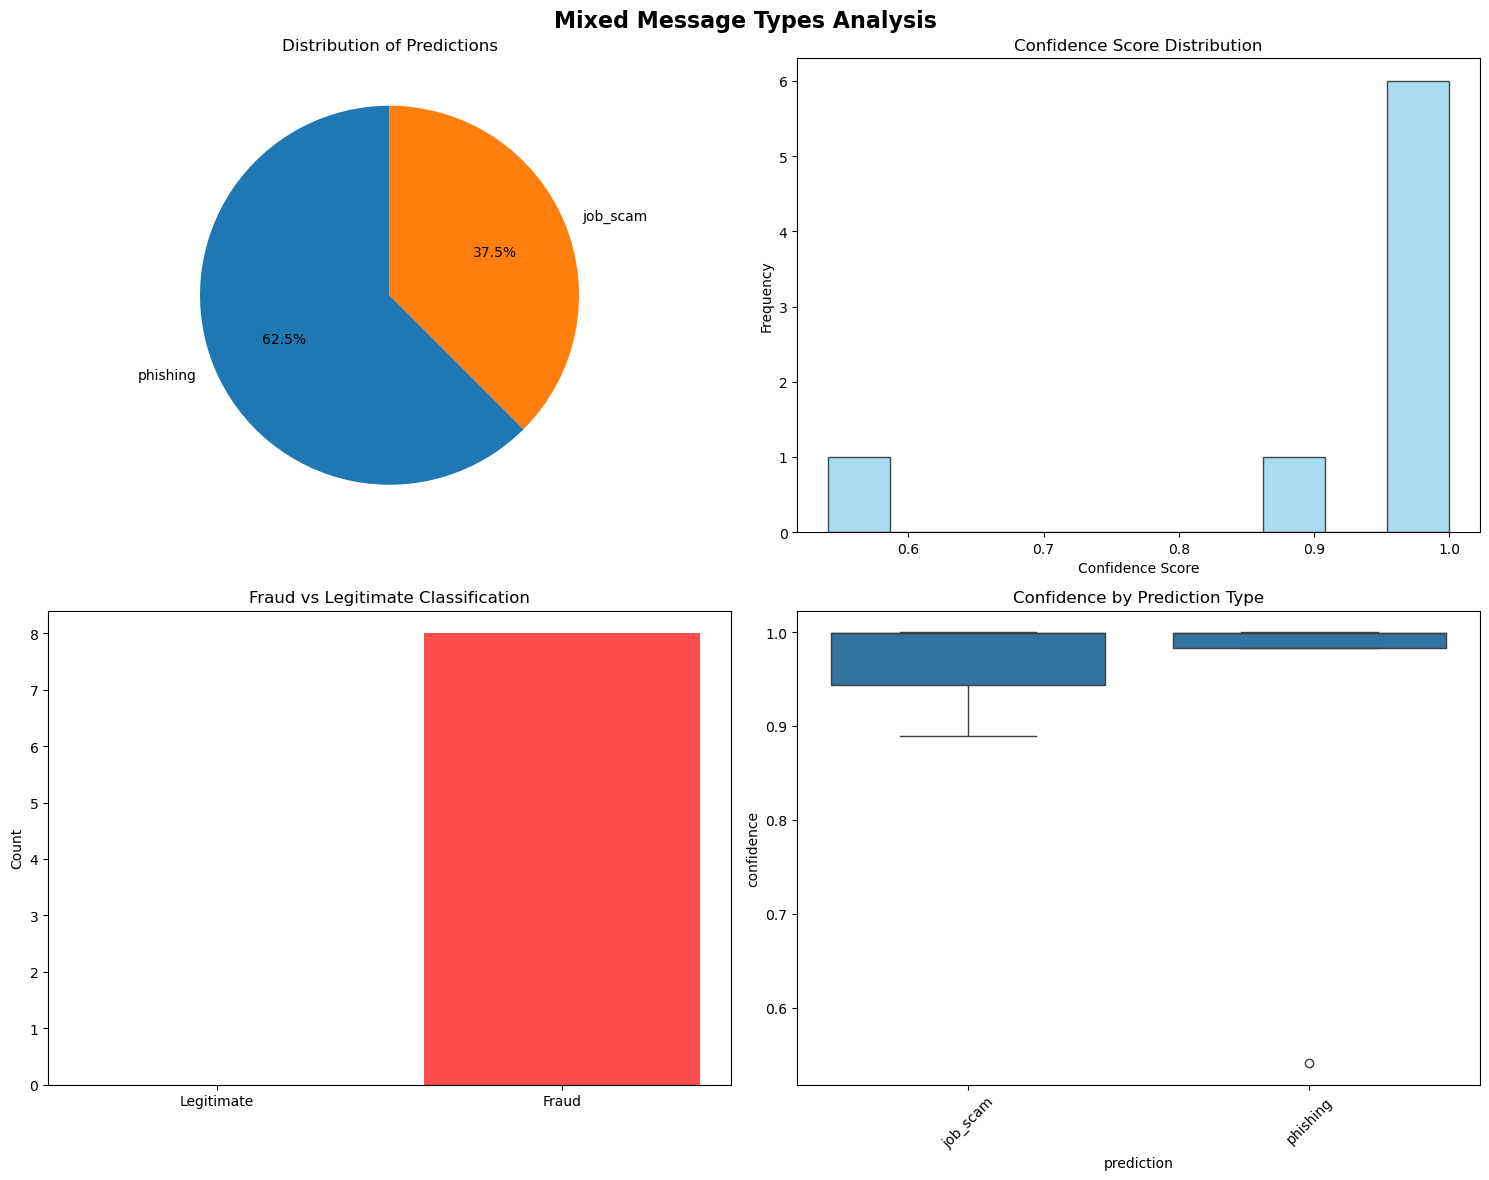


📋 Summary Results:
------------------------------------------------------------
 1. 🚨 FRAUD | job_scam        | 0.999 | Hi John, the meeting is at 2 PM
 2. 🚨 FRAUD | phishing        | 1.000 | URGENT: Your account is compromised, click here
 3. 🚨 FRAUD | phishing        | 0.983 | Congratulations! You won $10,000! Send fee to clai...
 4. 🚨 FRAUD | phishing        | 0.999 | Your computer has viruses, call us now
 5. 🚨 FRAUD | job_scam        | 0.889 | Thanks for your order, shipping tomorrow
 6. 🚨 FRAUD | phishing        | 0.541 | Work from home! Make $5000/week! Send $99 to start
 7. 🚨 FRAUD | job_scam        | 1.000 | Happy birthday! See you at the party
 8. 🚨 FRAUD | phishing        | 0.999 | Your Netflix payment failed, update now


In [12]:
# Test with a mixed batch of messages
mixed_examples = [
    "Hi John, the meeting is at 2 PM",  # legitimate
    "URGENT: Your account is compromised, click here",  # phishing
    "Congratulations! You won $10,000! Send fee to claim",  # reward scam
    "Your computer has viruses, call us now",  # tech support
    "Thanks for your order, shipping tomorrow",  # legitimate
    "Work from home! Make $5000/week! Send $99 to start",  # job scam
    "Happy birthday! See you at the party",  # legitimate
    "Your Netflix payment failed, update now",  # refund scam
]

print("📊 Creating visualizations for mixed examples...")
results = visualize_predictions(mixed_examples, "Mixed Message Types Analysis")

# Print summary
print("\n📋 Summary Results:")
print("-" * 60)
for i, result in enumerate(results, 1):
    text_preview = result['text'][:50] + '...' if len(result['text']) > 50 else result['text']
    fraud_status = "🚨 FRAUD" if result['is_fraud'] else "✅ SAFE"
    print(f"{i:2d}. {fraud_status} | {result['predicted_class']:15s} | {result['confidence']:.3f} | {text_preview}")

## 🔄 Batch Testing

You can also test multiple messages at once for efficiency.

In [13]:
def predict_batch(texts, max_length=128, batch_size=16):
    """
    Predict fraud types for multiple texts efficiently
    """
    results = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        
        # Tokenize batch
        inputs = tokenizer(
            batch_texts,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Move to device
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        
        # Get predictions
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probabilities = torch.softmax(logits, dim=1)
            predicted_classes = torch.argmax(logits, dim=1)
            confidences = torch.max(probabilities, dim=1)[0]
        
        # Format batch results
        for j, text in enumerate(batch_texts):
            predicted_class_id = predicted_classes[j].item()
            predicted_class = CLASS_LABELS[predicted_class_id]
            confidence = confidences[j].item()
            
            results.append({
                'text': text,
                'predicted_class': predicted_class,
                'confidence': confidence,
                'is_fraud': predicted_class != 'legitimate'
            })
    
    return results

# Example batch prediction
batch_texts = [
    "Your Amazon order has been shipped",
    "URGENT: Verify your social security number",
    "Meeting at 3 PM in conference room A",
    "You've won a free vacation! Call now!",
    "Reminder: Doctor appointment tomorrow"
]

print("⚡ Running batch prediction...")
batch_results = predict_batch(batch_texts)

print("\n📊 Batch Results:")
print("-" * 80)
for i, result in enumerate(batch_results, 1):
    status = "🚨" if result['is_fraud'] else "✅"
    print(f"{i}. {status} {result['predicted_class']:15s} ({result['confidence']:.3f}) - {result['text']}")

⚡ Running batch prediction...

📊 Batch Results:
--------------------------------------------------------------------------------
1. 🚨 phishing        (0.968) - Your Amazon order has been shipped
2. 🚨 phishing        (1.000) - URGENT: Verify your social security number
3. 🚨 job_scam        (1.000) - Meeting at 3 PM in conference room A
4. 🚨 sms_spam        (0.991) - You've won a free vacation! Call now!
5. 🚨 phishing        (0.890) - Reminder: Doctor appointment tomorrow


## ℹ️ Model Information

Let's examine some details about your trained model.

In [14]:
# Display model information
print("🔍 Model Information:")
print("=" * 50)
print(f"Model Type: {model.__class__.__name__}")
print(f"Number of Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"Model Device: {next(model.parameters()).device}")
print(f"Model Precision: {next(model.parameters()).dtype}")

print(f"\n📋 Configuration:")
print(f"Number of Classes: {model.config.num_labels}")
print(f"Hidden Size: {model.config.hidden_size}")
print(f"Number of Layers: {model.config.num_hidden_layers}")
print(f"Number of Attention Heads: {model.config.num_attention_heads}")
print(f"Max Position Embeddings: {model.config.max_position_embeddings}")

print(f"\n🎯 Class Labels:")
for i, label in enumerate(CLASS_LABELS):
    print(f"  {i}: {label}")

print(f"\n📊 Tokenizer Info:")
print(f"Vocabulary Size: {tokenizer.vocab_size:,}")
print(f"Model Max Length: {tokenizer.model_max_length}")

🔍 Model Information:
Model Type: BertForSequenceClassification
Number of Parameters: 109,489,161
Trainable Parameters: 109,489,161
Model Device: cpu
Model Precision: torch.float32

📋 Configuration:
Number of Classes: 9
Hidden Size: 768
Number of Layers: 12
Number of Attention Heads: 12
Max Position Embeddings: 512

🎯 Class Labels:
  0: legitimate
  1: job_scam
  2: phishing
  3: popup_scam
  4: refund_scam
  5: reward_scam
  6: sms_spam
  7: ssn_scam
  8: tech_support_scam

📊 Tokenizer Info:
Vocabulary Size: 30,522
Model Max Length: 512



### 🚀 Next Steps
1. **Test with real data**: Use actual messages you want to classify
2. **Integrate into applications**: Use the prediction functions in web apps or APIs
3. **Monitor performance**: Track accuracy on new data
4. **Retrain as needed**: Update the model with new fraud patterns

### 💡 Tips for Production Use
- **Batch processing**: Use `predict_batch()` for efficiency with multiple messages
- **Confidence thresholds**: Consider predictions with confidence < 0.5 as uncertain
- **Human review**: Have humans review uncertain cases
- **Regular updates**: Retrain the model periodically with new data

### 🔧 Customization
- **Adjust confidence thresholds**: Modify what you consider "high confidence"
- **Add new classes**: Retrain the model with additional fraud types
- **Fine-tune further**: Continue training on domain-specific data

